# Welcome to our BME300 Capstone Project
### In this program, we plan to test our algorithm with the 16 electrode Icelandic EHG database.  

### Importing Necessary Libraries

In [52]:
from attr import define
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import serial
import keyboard as kb
import time
import math
from scipy.signal import savgol_filter
import scipy

ind=11

In [53]:
import streamlit as st
import plotly.express as px

### Data Collection from Physionet
The dataset we plan to use is the Icelandic 16-electrode Electrohysterogram Database
https://physionet.org/content/ehgdb/1.0.0/
We saved the database locally to our drive
Fortunately Physionet provides the wfdb library with the help of which we can easily extract EHG values from each patient reading.
This database contains 122 readings of 45 patients. (10 of them were in labor)

In [54]:
# Data Collection:
dat_file=r'C:\Drive\BME 300\icelandic-16-electrode-electrohysterogram-database-1.0.0\files\ice008_p_2of4'
#dat_file=r'C:\Drive\BME 300\icelandic-16-electrode-electrohysterogram-database-1.0.0\files\ice031_l_3of3'
wfdb.rdheader(dat_file)
ind+=1


In [55]:
record=wfdb.rdrecord(dat_file,channels=[1,3])
record

In [56]:
signals, fields= wfdb.rdsamp(dat_file,sampfrom=200000,sampto=720000,channels=[1,2])
signals1, fields1= wfdb.rdsamp(dat_file,sampfrom=0,channels=[1,2])
signals.shape

(520000, 2)

In [57]:
fields

{'fs': 200,
 'sig_len': 520000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['EHG10', 'EHG11'],
 'comments': ['Info:',
  'ID:ice008',
  'Record type:pregnancy',
  'Record number:2/4',
  'Age(years):26',
  'BMI before pregnancy:20.9',
  'BMI at recording:25.3',
  'Gravidity:5',
  'Parity:2',
  'Previous caesarean:No',
  'Placental position:Anterior',
  'Gestational age at recording(w/d):37/6',
  'Gestational age at delivery:40/2',
  'Mode of delivery:Vaginal',
  'Synthetic oxytocin use in labour:No',
  'Epidural during labour:No',
  'Comments for recording:',
  'Comments for delivery:']}

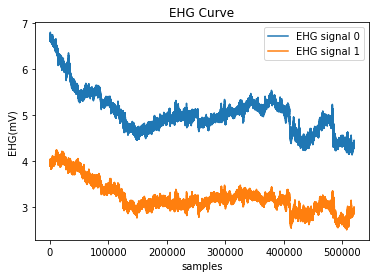

In [71]:
#for i in signals[:,1]:
    #print(i)
plt.plot(signals[:,0]) 
plt.plot(signals[:,1])
plt.title("EHG Curve")
plt.xlabel("samples")
plt.ylabel("EHG(mV)")
plt.legend(['EHG signal 0','EHG signal 1'])

Creating a time-array for further analysis

In [59]:
secs=len(signals1[:,1])/(200)
mins=secs/60
y=signals[:,1]
y=list(y)
x=np.arange(0,secs,1/200)
x.shape
#x=x[250000:670000,]
x=x[200000:720000,]
x.shape
x=list(x)
len(y)

520000

### Filtering the EHG reading
We use a Savitzky-Golay filter as it has shown better results than other filters

In [60]:
y_unfiltered=y

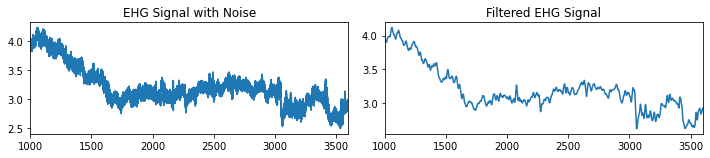

In [61]:
y=savgol_filter(y_unfiltered,4500,2)


plt.figure(figsize=(10, 4))

plt.subplot(221)
plt.plot(x, y_unfiltered)
plt.title("EHG Signal with Noise")
plt.margins(0, .05)

plt.subplot(222)
plt.plot(x, y)
plt.title("Filtered EHG Signal")
plt.margins(0, .05)

plt.tight_layout()
plt.show()

Making an EHG dataframe containing raw and filtered signals in case we need it.

In [ ]:
ehg_y=list(y)
ehg_y_unfiltered=list(y_unfiltered)
ehg_np=[x,ehg_y,ehg_y_unfiltered]
ehg_np=np.array(ehg_np)
ehg_np=ehg_np.T
ehg_df=pd.DataFrame(ehg_np,columns=["time","Filtered_EHG","Raw_EHG"])
ehg_df

## Preterm Labor Detection
We start the preterm labor detection now
### Preprocessing
For preterm labor, the data is sliced into 3 minute windows.

We also define two functions: one to determine index of peak values within that 3 minute window and another to determine percentage of difference of values(peak or time gap) between two windows.

In [10]:
#Data PreProcessing:
freq=200 # 20Hz sampling frequency
minutes=3
slice_time= minutes*60 # 3 minutes
slice_size= slice_time*freq

sample_size=len(x)
slice_num=math.floor(sample_size/slice_size)
x_sliced= [x[i*slice_size:(i+1)*slice_size] for i in range(0,slice_num)]
y_sliced= [y[i*slice_size:(i+1)*slice_size] for i in range(0,slice_num)]

x_sliced=np.array(x_sliced)
y_sliced=np.array(y_sliced)  #now time and voltage has been successfully divided into segments of 30 mins or 36,000 samples

def findPeakIndex(y):
    y=np.array(y)
    c=y.argmax()

    return c

def percDiff(val1,val2):
    valM=abs(val1-val2)
    valP=abs(val1+val2)/2
    perDiff=(valM/valP)*100
    return perDiff


The following code evaluates the variability between peak values and time gaps between peaks of adjacent 3-minute windows.
A final decision is provided on every 3-minute window.

Finally, it is checked how much percentage of all the windows are inconsistent. 

In [80]:
# Data Analysis:
final_Decision=list()
Threshold=70
for i in range(0,len(x_sliced)):
    FD=0
    PFC=0
    fPFC=0
    PRPD=0
    peaksFD=0
    freqFD=0
    t=x_sliced[i,:]
    volt_raw=y_sliced[i,:]
    volt=savgol_filter(volt_raw,4500,2)
    #print(volt)
    print('i='+ str(i))
    # phase-1
    sd_threshold=0.1
    sd=np.std(volt)
    if sd<sd_threshold:
        FD=0;
    else:
        #phase-2
        percent=5
        segments=math.floor(100/percent)
        segment_size= (percent/100)*len(t)
        segment_size=int(segment_size)
        #print("segment size")
        #print(segment_size)
        t05=[t[p*segment_size:(p+1)*segment_size] for p in range(0,segments)]
        volt05=[volt[p*segment_size:(p+1)*segment_size] for p in range(0,segments)]
        #print(volt05)
        for j in range(0,len(t05)):
            #print('j='+ str(j))
            tp=t05[j]
            voltp=volt05[j]
            #print(len(tp))

            chunk_size=100
            chunk_num=int(len(tp)/chunk_size)
            #print("chunk num")
            #print(chunk_num)
            t_chunked=[tp[p*chunk_size:(p+1)*chunk_size] for p in range(0,chunk_num)]
            volt_chunked=[voltp[p*chunk_size:(p+1)*chunk_size] for p in range(0,chunk_num)]
            #print(volt_chunked)
            #Peaks Analysis
            for k in range(0,len(volt_chunked)-1):
                #print('k='+ str(k))
                #print(volt_chunked[k])
                #print(volt_chunked[k+1])
                ind1=findPeakIndex(volt_chunked[k])
                ind2=findPeakIndex(volt_chunked[k+1])
                peak1=volt_chunked[k][ind1]
                peak2=volt_chunked[k+1][ind2]
                PDR=percDiff(peak1,peak2)
                if PDR>14:
                    PFC+=1
            PRPD=(PFC*100)/len(volt_chunked) 
            if PRPD>25:
                peaksFD+=5
            
            #Frequency Analysis
            for k in range(0,len(volt_chunked)-2):
                ind1=findPeakIndex(volt_chunked[k])
                ind2=findPeakIndex(volt_chunked[k+1])
                ind3=findPeakIndex(volt_chunked[k+2])
                time1=t_chunked[k][ind1]
                time2=t_chunked[k+1][ind2]
                time3=t_chunked[k+2][ind3]
                freq1=time2-time1
                freq2=time3-time2
                fPDR=percDiff(freq1,freq2)
                if fPDR>14:
                    fPFC+=1
            fPRPD=(fPFC*100)/len(volt_chunked) 
            if fPRPD>25:
                freqFD+=5
        FD=(peaksFD+freqFD)
    #Final Decision Analysis
    print(FD)
    if FD>=Threshold:
        final_Decision.append(1)
    else:
        final_Decision.append(0)
        
preterm_perc=sum(final_Decision)/len(final_Decision)*100
print("Percentage of windows that show inconsistency akin to labor:")
print(preterm_perc)
        

i=0
0
i=1
90
i=2
0
i=3
65
i=4
0
i=5
0
i=6
0
i=7
0
i=8
0
i=9
0
i=10
0
i=11
75
i=12
80
i=13
70
Percentage of windows that show inconsistency akin to labor:
28.57142857142857


## Baseline Deflection
Baseline deflection is measured by integrating to find the area under the EHG curve

Baseline Deflection is:
2.989538159337386


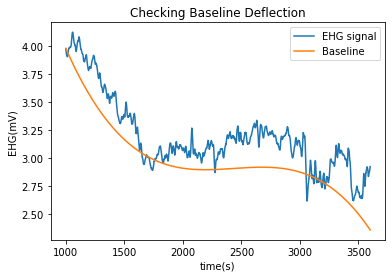

In [70]:
import peakutils
y=np.array(y)
y_baseline=peakutils.baseline(y)

plt.plot(x,y)
plt.plot(x,y_baseline)
plt.xlabel("time(s)")
plt.ylabel("EHG(mV)")
plt.title("Checking Baseline Deflection")
plt.legend(['EHG signal','Baseline'])


baseline_deflection=(np.trapz(y_baseline))/len(y)

print("Baseline Deflection is:")
print(baseline_deflection)

## Frequency Determination
Frequency determination is done by counting no. of onsets in unit time. Onsets are determined with the help of the powerful Biosignal Processing Python Module

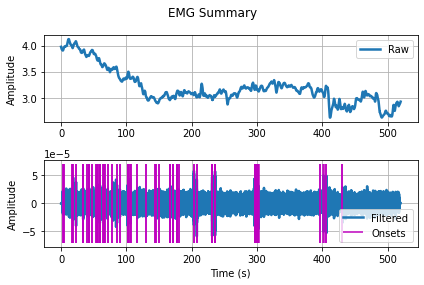

EHG onset frequency:
2.0666695370410237


In [73]:
import biosppy
ehg_bio=biosppy.signals.emg.emg(y)
ehg_freqs=len(ehg_bio['onsets'])/x[-1]*60
print("EHG onset frequency:")
print(ehg_freqs)

## Montevideo Units
Montevideo units are calculated by subtracting the baseline uterine pressure from the peak contraction pressure of each contraction (arrows) in a 10-minute window and adding the pressures generated by each contraction.

So, the Uterine pressure data needs to be sliced into 10 minute windows


In [18]:
freq=200 # 20Hz sampling frequency
minutes=10
slice_time= minutes*60  # 10 minutes
slice_size= slice_time*freq

sample_size=len(x)
slice_num=math.floor(sample_size/slice_size)


Again, the EHG data is converted to uterine pressure using the following equation:
(y_pressure is uterine pressure, y is EHG values)
https://sci-hub.hkvisa.net/10.1007/s10916-020-1523-y

In [74]:
y_pressure=38.71-2.764*y+0.7966*y**2
y_pressure_baseline=peakutils.baseline(y_pressure)
y_dist=y_pressure-y_pressure_baseline
y_dist_sliced= [y_dist[i*slice_size:(i+1)*slice_size] for i in range(0,slice_num)]
MVUarray=[]
for i in range(0,len(y_dist_sliced)):
    MVUarray.append(sum(y_dist_sliced[i])/slice_time)
MVUarray=np.array(MVUarray)
MVU=np.mean(MVUarray)


All our features extracted are stored in a dictionary later converted to a dataframe.

In [76]:
patient= {}
patient['Preterm_Contraction']=preterm_perc
patient['Baseline_Deflection']=baseline_deflection
patient['EHG_frequency']=ehg_freqs
patient['Montevideo_Units']=MVU


In [77]:
patient

{'Preterm_Contraction': 28.57142857142857,
 'Baseline_Deflection': 2.989538159337386,
 'EHG_frequency': 2.0666695370410237,
 'Montevideo_Units': 67.34808724160195}

In [78]:
patient_df=pd.DataFrame(patient,index=[ind])
patient_df

,Preterm_Contraction,Baseline_Deflection,EHG_frequency,Montevideo_Units
12,28.571429,2.989538,2.06667,67.348087


The dataframe is appended to a csv

In [88]:
patient_df.to_csv(r'C:\Drive\BME 300\Feature_Extraction_using_Icelandic_Dataset.csv',mode='a',index=True,header=False)

In [79]:
print("Done")

Done
